<a href="https://colab.research.google.com/github/daniel3400-ui/NIDS/blob/main/NetworkIntrusionDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading datasets and necessary librarties

In [ ]:
api_token = {'username':'dan3400','key':'9b82535427f04dc819df62ffb3dc2415'}

import os
import json
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, average_precision_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from itertools import cycle

os.makedirs('/root/.kaggle/', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

In [ ]:
!kaggle datasets download chethuhn/network-intrusion-dataset

Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset
License(s): CC0-1.0
 99% 228M/230M [00:17<00:00, 17.1MB/s]
100% 230M/230M [00:17<00:00, 13.5MB/s]


In [ ]:
!unzip network-intrusion-dataset.zip

Archive:  network-intrusion-dataset.zip
  inflating: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: Monday-WorkingHours.pcap_ISCX.csv  
  inflating: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: Wednesday-workingHours.pcap_ISCX.csv  


### Dataset Analysis and Preprocessing of the CICIDS2017 Dataset.

In [ ]:
# Load the dataset
dataset_path = 'MachineLearningCSV/MachineLearningCVE'
files = os.listdir(dataset_path)

#Combine all files into one
data = pd.concat([pd.read_csv(os.path.join(dataset_path, file)) for file in files])

In [ ]:
data.info() #Displays the shape of the dataset and a summary of data types.

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [ ]:
#Searches the database for missing values and removes them.
missing_vals = data.isnull().sum()
print('Num missing vals:')
print(missing_vals[missing_vals > 0])

clean_data = data.dropna()

print(f'Datashape before removing missing vals: {data.shape}')
print(f'Datashape after removing: {clean_data.shape}')

data = data.dropna()

Num missing vals:
Flow Bytes/s    1358
dtype: int64
Datashape before removing missing vals: (2830743, 79)
Datashape after removing: (2829385, 79)


In [ ]:
#Searches the database for columns containing only 0 values and removes them.
zero_cols = (data == 0).all()

# Print out columns containing zeros
print('Columns containing 0s:')
print(zero_cols[zero_cols].index.tolist())

# Remove these columns from the DataFrame
data= data.drop(columns=zero_cols[zero_cols].index)


Columns containing 0s:
[' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


Traffic Type
Benign    2272688
Attack     556697
Name: count, dtype: int64


<ipython-input-23-c054f202c4f0>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_count .index, y=traffic_count.values, palette=['skyblue', 'red'])


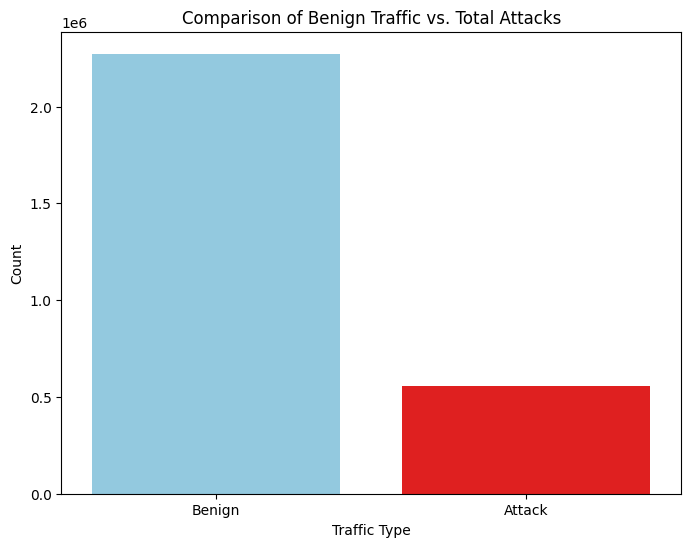

In [ ]:
#This code plots a graph of the number of benign attacks in comparison to the numer of total attacks.
#Creates a Traffic Type Column which labels traffic as either bengin or attack.
data['Traffic Type'] = data[' Label'].apply(lambda x: 'Benign' if x == 'BENIGN' else 'Attack')

print(data['Traffic Type'].value_counts()) #Displays ammount of data in traffic type

# Count the number of each category in traffic Type
traffic_count = data['Traffic Type'].value_counts()

# Plots data
plt.figure(figsize=(8, 6))
sns.barplot(x=traffic_count .index, y=traffic_count.values, palette=['skyblue', 'red'])
plt.title('Comparison of Benign Traffic vs. Total Attacks')
plt.ylabel('Count')
plt.xlabel('Traffic Type')
plt.xticks(rotation=0)
plt.show()


Resampled data shape: (1211634, 72)


<ipython-input-24-2d6f4161da0c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_type_counts_resampled.index, y=traffic_type_counts_resampled.values, palette=['skyblue', 'red'])


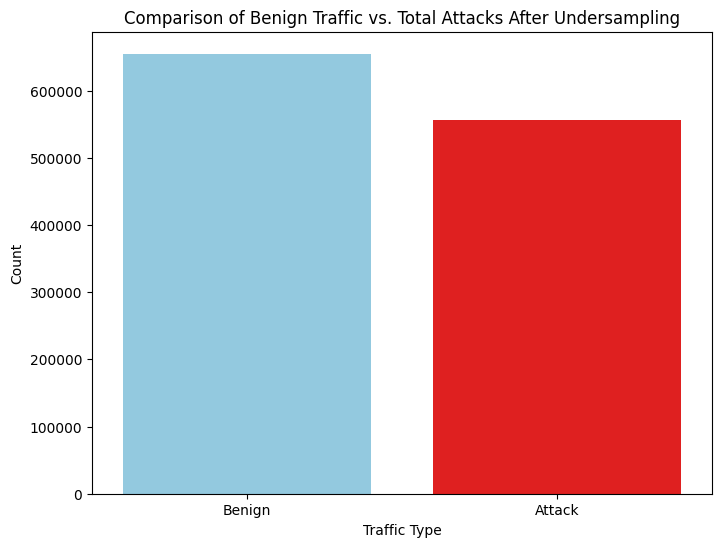

In [ ]:
#This code randomly undersamples the benign class in order to make the dataset more balanced.

rus = RandomUnderSampler(random_state=10, sampling_strategy=0.85)  #Initalises the random undersampler

X = data.drop(['Traffic Type'], axis=1)  #Drops traffic type column
y = data['Traffic Type']


X_res, y_res = rus.fit_resample(X, y) #Fits the random undersampler to the data


resampled_data = pd.DataFrame(X_res, columns=X.columns) #Creates a new dataframe from the resampled features.
resampled_data['Traffic Type'] = y_res #Adds traffic type column

print('Resampled data shape:', resampled_data.shape)

#Plots a new graph of benign traffic vs attacks from resampled data.
traffic_type_counts_resampled = resampled_data['Traffic Type'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=traffic_type_counts_resampled.index, y=traffic_type_counts_resampled.values, palette=['skyblue', 'red'])
plt.title('Comparison of Benign Traffic vs. Total Attacks After Undersampling')
plt.ylabel('Count')
plt.xlabel('Traffic Type')
plt.xticks(rotation=0)
plt.show()

data = resampled_data

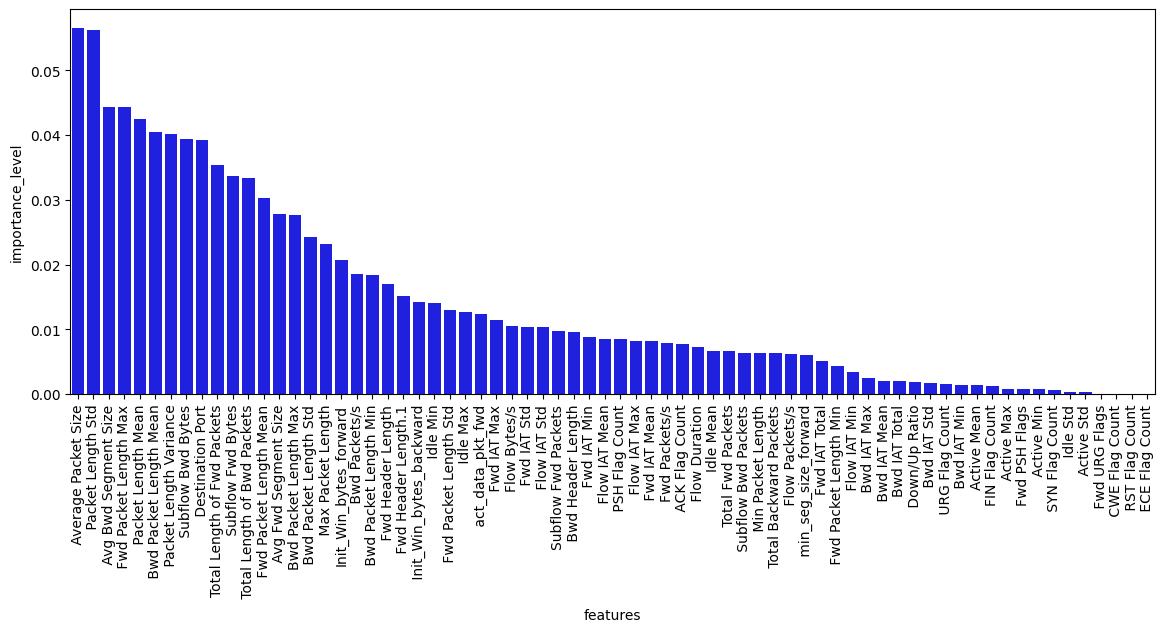

(1211634, 72)


In [ ]:
#Uses random forest to find out the most important features

labels = data.loc[:, ' Label']
features = data.iloc[:, :-2]

# Replace positive infinity values with nan
features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values with the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_features = imputer.fit_transform(features)

# Initializes random forest
rfc = RandomForestClassifier(random_state=10, n_jobs=-1)

# Fit the random forest on the dataset
rfc.fit(imputed_features , labels)

# Extract important features
score = np.round(rfc.feature_importances_, 5)
importances = pd.DataFrame({'features': features.columns, 'importance_level': score})
importances = importances.sort_values('importance_level', ascending=False).set_index('features')

# Plot important features yay :)
plt.figure(figsize=(14, 5))
sns.barplot(x=importances.index, y='importance_level', data=importances, color='b')
plt.xticks(rotation='vertical')
plt.show()

print(data.shape)

In [ ]:
#Deletes less important features that don't meant the thresholddd!!
threshold = 0.001

delete_feature = importances.loc[importances['importance_level'] < threshold]

# Print out the deleted features
deleted = [features for features in delete_feature.index]

data.drop(columns=deleted, inplace = True)

print(data.shape)

(1211634, 62)


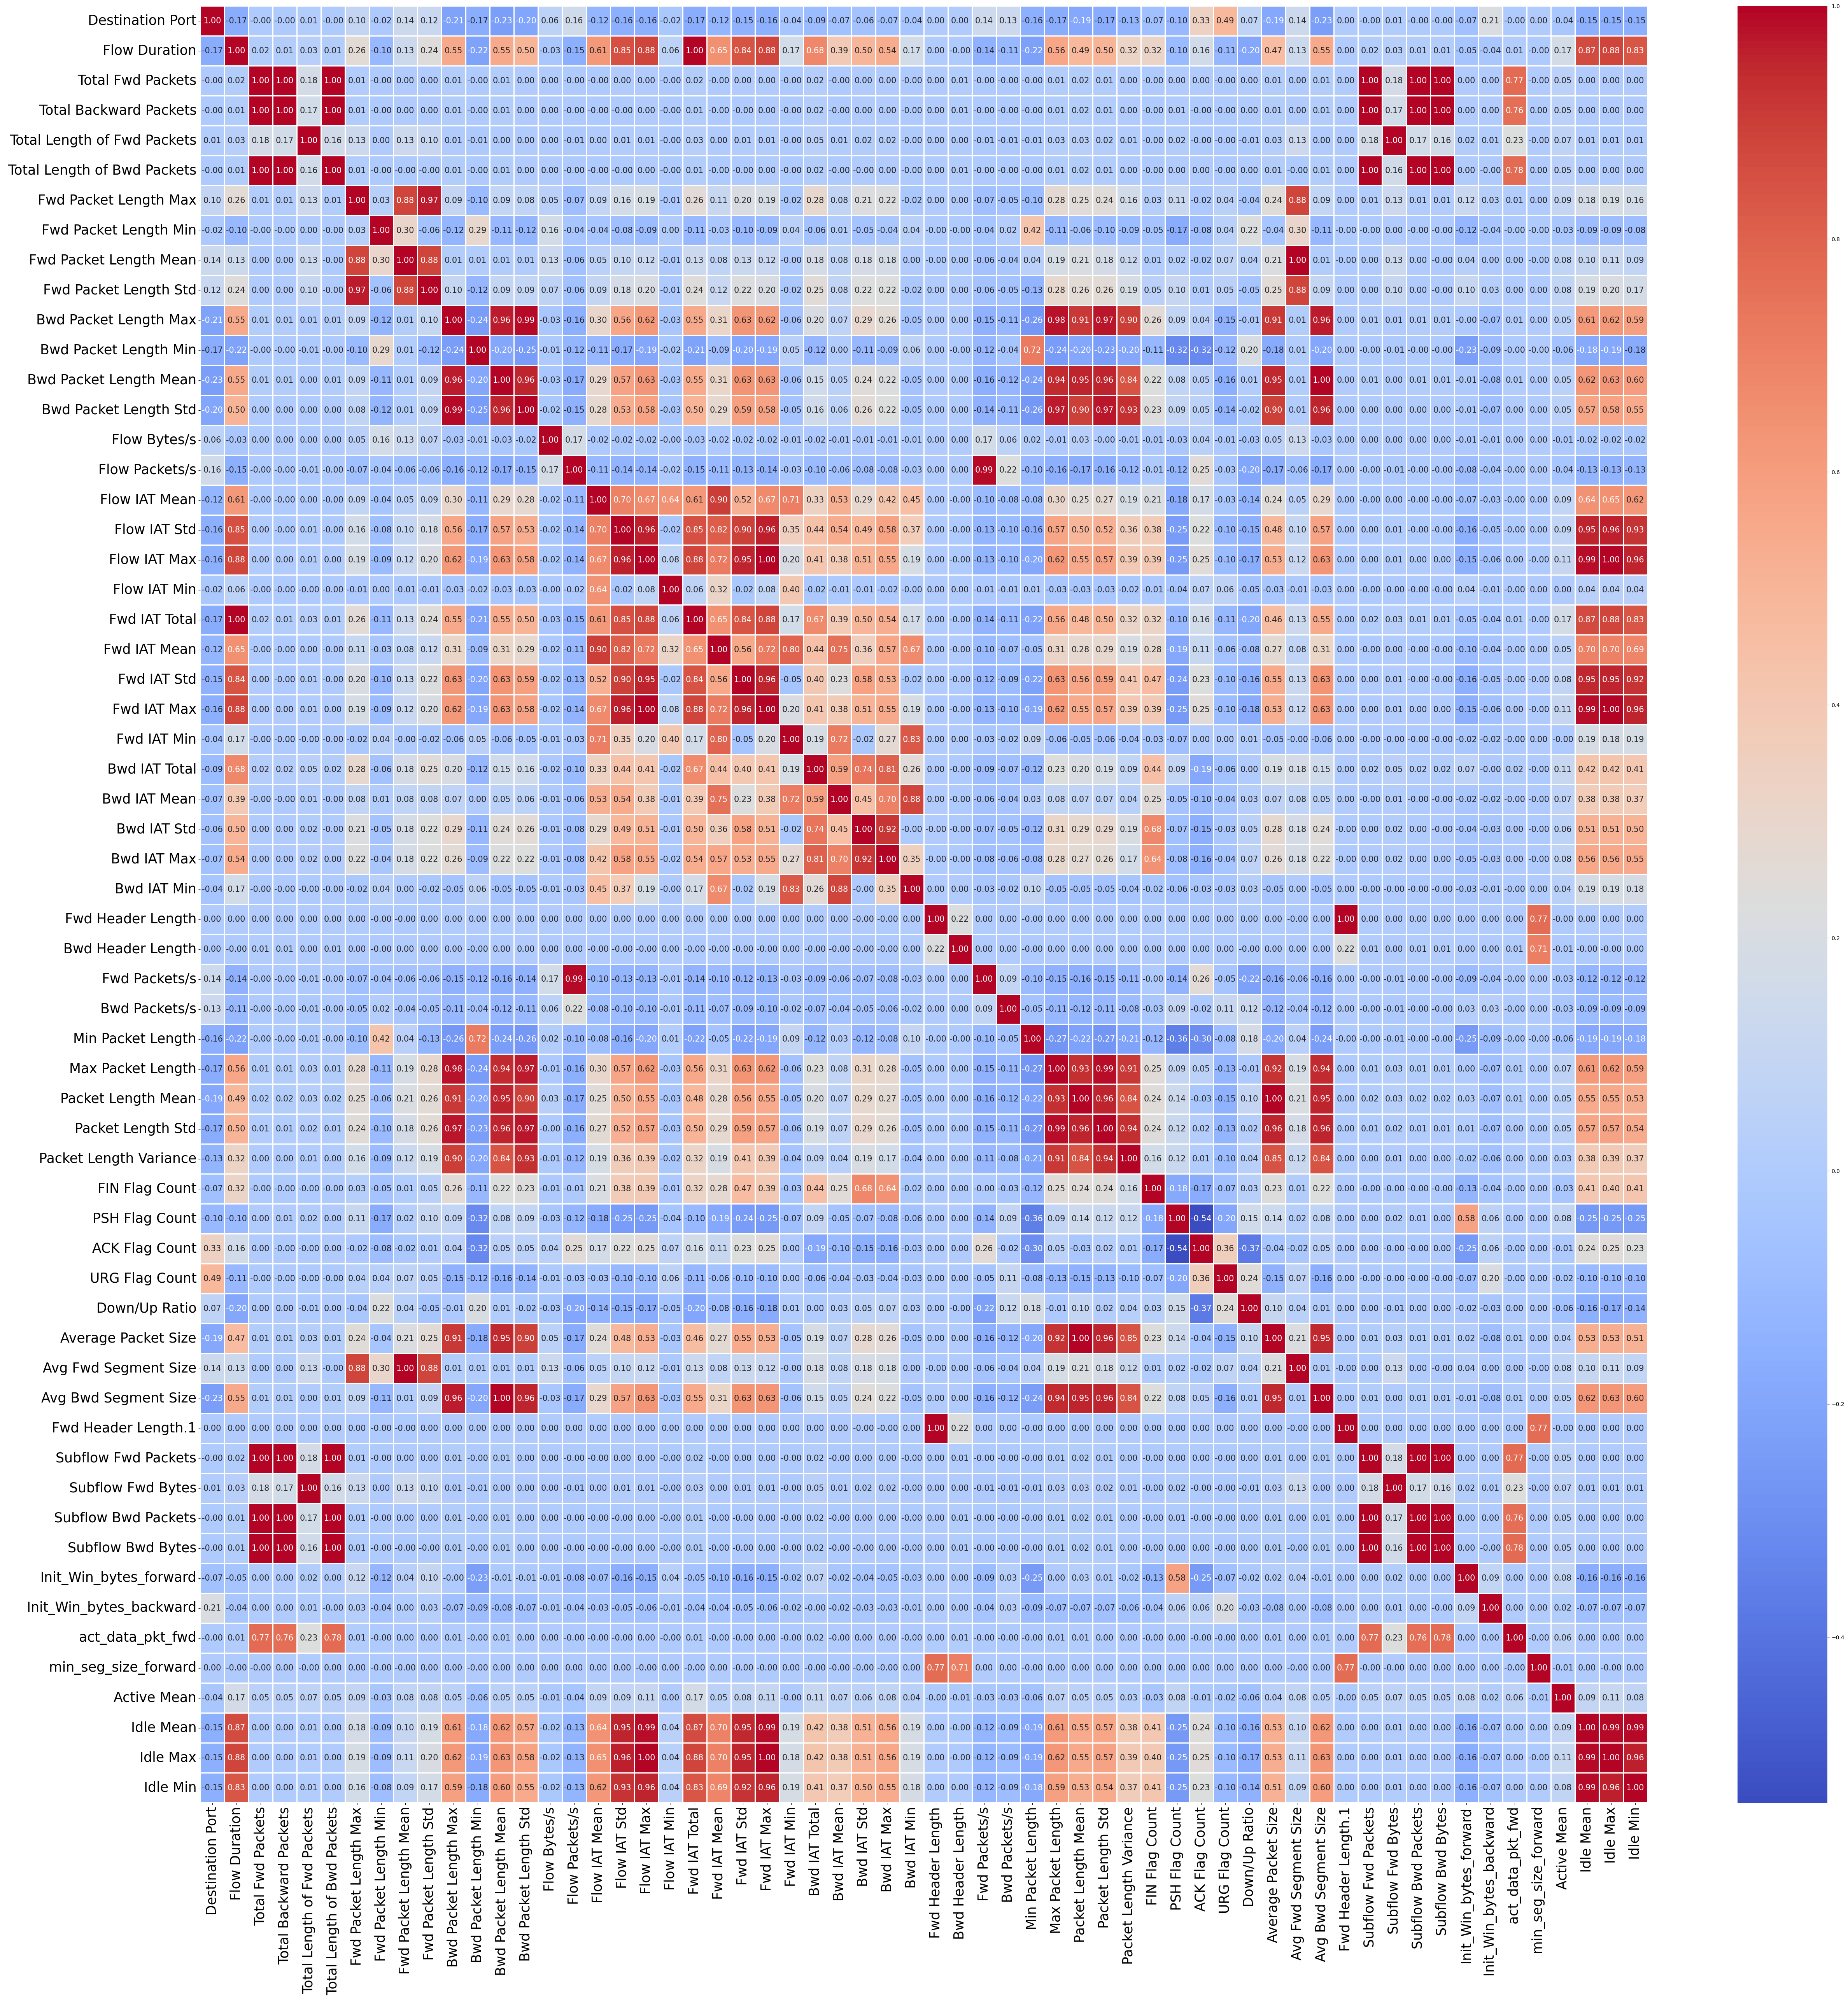

In [ ]:
#Find highly correlated pares
numeric_data = data.select_dtypes(include=[np.number])
correlated_data = numeric_data.corr()

plt.gcf().set_size_inches(60, 60)

# Plotting the heatmap!!
hm = sns.heatmap(correlated_data, annot=True, linewidths=.8, annot_kws={'fontsize':15}, fmt='.2f', cmap='coolwarm')
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
plt.savefig('corr_heatmap.png', dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
#Find highly correlated pairs

threshold = 0.95 #Threshold so only pairs above or equal to this threshold will be included.

correlated_pairs = []

#Loops through correlation matrix and finds any pairs that are above the threshold
for i in range(len(correlated_data.columns)):
    for j in range(i + 1, len(correlated_data.columns)):
        if abs(correlated_data.iloc[i, j]) >= threshold:
            correlated_pairs.append((correlated_data.columns[i], correlated_data.columns[j]))

print('Highly correlated pairs (|correlation| >= 0.95):')
for pair in correlated_pairs:
    print(f"{pair[0]} and {pair[1]}")

print(f'\nTotal number of highly correlated pairs: {len(correlated_pairs)}')


Highly correlated pairs (|correlation| >= 0.95):
 Flow Duration and Fwd IAT Total
 Total Fwd Packets and  Total Backward Packets
 Total Fwd Packets and  Total Length of Bwd Packets
 Total Fwd Packets and Subflow Fwd Packets
 Total Fwd Packets and  Subflow Bwd Packets
 Total Fwd Packets and  Subflow Bwd Bytes
 Total Backward Packets and  Total Length of Bwd Packets
 Total Backward Packets and Subflow Fwd Packets
 Total Backward Packets and  Subflow Bwd Packets
 Total Backward Packets and  Subflow Bwd Bytes
Total Length of Fwd Packets and  Subflow Fwd Bytes
 Total Length of Bwd Packets and Subflow Fwd Packets
 Total Length of Bwd Packets and  Subflow Bwd Packets
 Total Length of Bwd Packets and  Subflow Bwd Bytes
 Fwd Packet Length Max and  Fwd Packet Length Std
 Fwd Packet Length Mean and  Avg Fwd Segment Size
Bwd Packet Length Max and  Bwd Packet Length Mean
Bwd Packet Length Max and  Bwd Packet Length Std
Bwd Packet Length Max and  Max Packet Length
Bwd Packet Length Max and  Packet L

In [ ]:
#Removes highly correlated pairs

correlated_pairs = [(pair[0], pair[1]) for pair in correlated_pairs]

remove_columns = []

#Loops thorugh each pair of correlated pairs and puts them in the list of columns to remove
for pair in correlated_pairs:
    if pair[1] not in remove_columns:
        remove_columns.append(pair[1])

data = data.drop(columns=remove_columns) #Removes all highly correlated pairs

print(f'Columns removed: {remove_columns}')

Columns removed: ['Fwd IAT Total', ' Total Backward Packets', ' Total Length of Bwd Packets', 'Subflow Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes', ' Subflow Fwd Bytes', ' Fwd Packet Length Std', ' Avg Fwd Segment Size', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', ' Max Packet Length', ' Packet Length Std', ' Avg Bwd Segment Size', ' Packet Length Mean', 'Fwd Packets/s', ' Flow IAT Max', ' Fwd IAT Max', 'Idle Mean', ' Idle Max', ' Fwd IAT Std', ' Idle Min', ' Fwd Header Length.1', ' Average Packet Size']


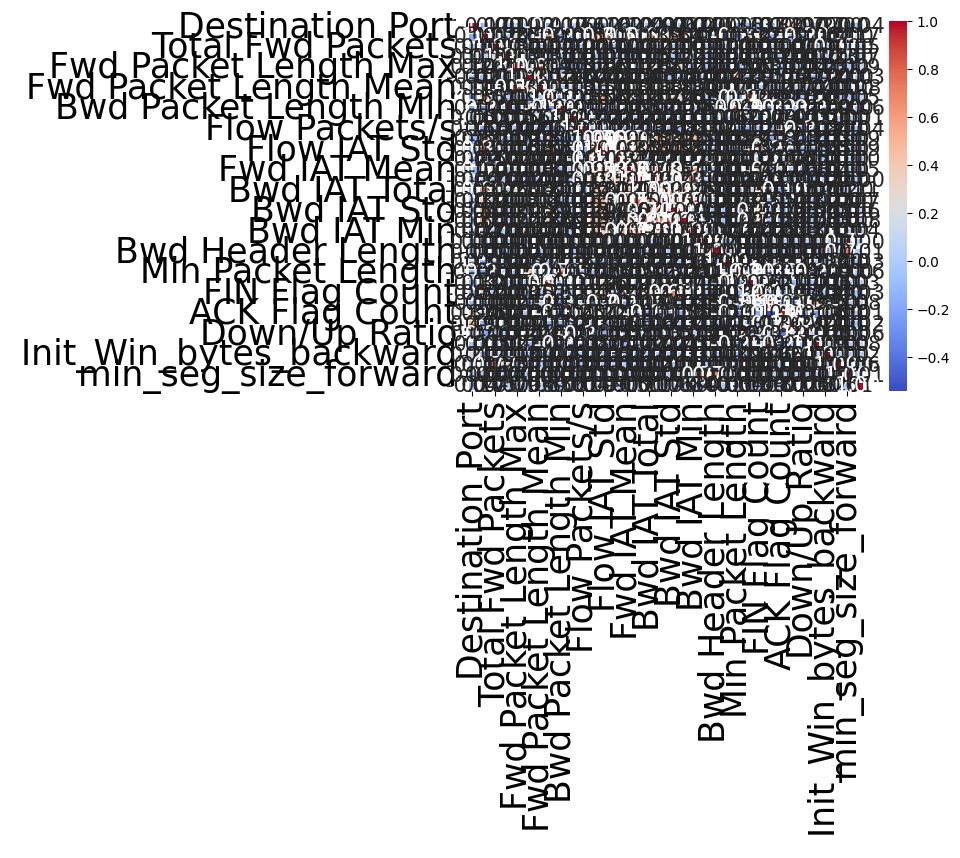

In [ ]:
#Find highly correlated pares
numeric_data = data.select_dtypes(include=[np.number])
correlated_data = numeric_data.corr()

# Plotting the heatmap
hm = sns.heatmap(correlated_data, annot=True, linewidths=.8, annot_kws={"fontsize":15}, fmt=".2f", cmap='coolwarm')
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
plt.savefig("corr_heatmap.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
#Convert CICIDS2017 dataset into binary classification.
data[' Label'] = data[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:

# Model Architecture
def CNN(input_shape):
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax', dtype='float32')
    ])
    return model


In [ ]:

# scaling the numeric features
qt = QuantileTransformer(random_state=10)
data_numeric = data.drop([" Label", "Traffic Type"], axis=1)
data_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
data_numeric.fillna(data_numeric.mean(), inplace=True)
data_scaled = qt.fit_transform(data_numeric)
data[data_numeric.columns] = data_scaled

features = data.drop([' Label', 'Traffic Type'], axis=1)
labels = data[' Label']

# reshape the features to make them suitable for cnn
features_reshaped = features.values.reshape(features.shape[0], 1, features.shape[1], 1)

# convert labels to categorical
labels_encoded = to_categorical(labels)

In [ ]:
Features_train, Features_val, Labels_train, Labels_val = train_test_split(features_reshaped, labels_encoded, test_size=0.20, random_state=42) #Split dataset.

In [ ]:


# Define KFold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train model using Cross Validaiton
fold_no = 1
results = []

for train_index, test_index in kf.split(Features_train):
    X_train, X_test = Features_train[train_index], Features_train[test_index]
    y_train, y_test = Labels_train[train_index], Labels_train[test_index]

    # Define learning rate paramaters
    initial_learning_rate = 0.001
    decay_steps = 10000
    decay_rate = 0.95

    # Create exponential decay learning rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(1024).prefetch(AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1024).prefetch(AUTOTUNE)

    model_cicds = CNN((1, features.shape[1], 1))
    optimizer = Adam(learning_rate=lr_schedule)
    model_cicds.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print("Training fold", fold_no)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model_cicds.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping])

    # model evaluation
    scores = model_cicds.evaluate(val_dataset, verbose=0)
    print(f'Score for fold {fold_no}: {model_cicds.metrics_names[0]} of {scores[0]}; {model_cicds.metrics_names[1]} of {scores[1]*100}%')
    results.append(scores)
    fold_no += 1

print("Results per fold: ", results)
print("Average accuracy across folds: ", np.mean([result[1] for result in results]))


Training fold 1
Epoch 1/50
758/758 [==============================] - 12s 6ms/step - loss: 0.0646 - accuracy: 0.9769 - val_loss: 0.0202 - val_accuracy: 0.9931
Epoch 2/50
758/758 [==============================] - 6s 6ms/step - loss: 0.0253 - accuracy: 0.9920 - val_loss: 0.0148 - val_accuracy: 0.9958
Epoch 3/50
758/758 [==============================] - 6s 6ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0117 - val_accuracy: 0.9968
Epoch 4/50
758/758 [==============================] - 6s 6ms/step - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.0105 - val_accuracy: 0.9970
Epoch 5/50
758/758 [==============================] - 6s 6ms/step - loss: 0.0164 - accuracy: 0.9952 - val_loss: 0.0107 - val_accuracy: 0.9970
Epoch 6/50
758/758 [==============================] - 6s 6ms/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.0098 - val_accuracy: 0.9971
Epoch 7/50
758/758 [==============================] - 6s 6ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0098 - val_accura

KeyboardInterrupt: 

7573/7573 [==============================] - 12s 2ms/step
Confusion Matrix:
 [[130604    267]
 [    49 111407]]
Classification Report:
               precision    recall  f1-score   support

           0   0.999625  0.997960  0.998792    130871
           1   0.997609  0.999560  0.998584    111456

    accuracy                       0.998696    242327
   macro avg   0.998617  0.998760  0.998688    242327
weighted avg   0.998698  0.998696  0.998696    242327



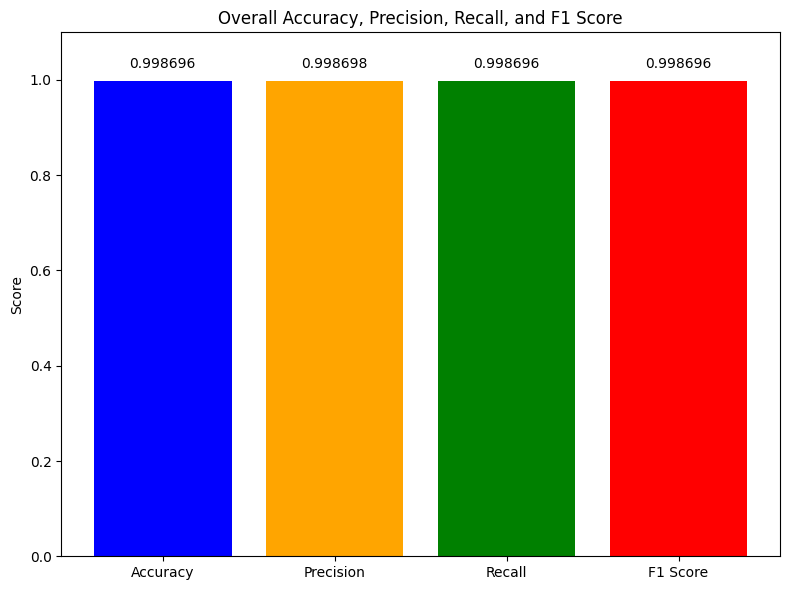

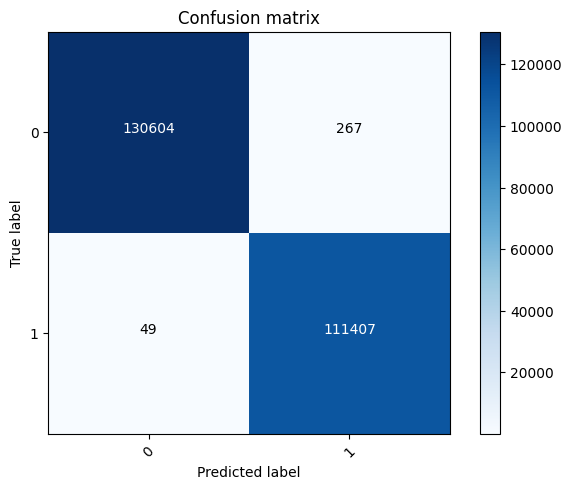

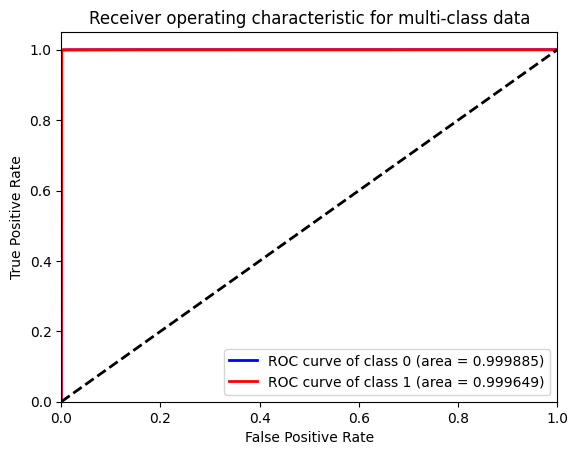

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:

Features_val = Features_val[:, :, :35, :]

# Make predictions
predictions = model_cicids.predict(Features_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Labels_val, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

# Calculate Precision, Recall, F1-Score
cr = classification_report(true_classes, predicted_classes, digits=6, output_dict=True)
print("Classification Report:\n", classification_report(true_classes, predicted_classes, digits=6))

precision = cr['weighted avg']['precision']
recall = cr['weighted avg']['recall']
f1_score = cr['weighted avg']['f1-score']
accuracy = cr['accuracy']

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1_score]
})

# Plot the overall metrics
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1.1)
plt.title('Overall Accuracy, Precision, Recall, and F1 Score')
plt.ylabel('Score')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.6f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(cm, classes=[str(cls) for cls in np.unique(true_classes)], title='Confusion matrix')
plt.show()

# Calculate ROC Curve
n_classes = Labels_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Labels_val[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve graph
colors = cycle(['blue', 'red', 'green'])
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Plot training and validation accuracy graphs
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training and validation loss values graphs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
#Generating adversarial examples and creating a adversarial dataset containing normal and adversarial exmaples


# loads pre trained model
model = tf.keras.models.load_model('model_cicids.h5')

# Ensure features are in correct shape
features_reshaped = features_reshaped.astype(np.float32)
features_reshaped = features_reshaped[:, :, :35, :]

# split dataset
Features_train, Features_val, Labels_train, Labels_val = train_test_split(
    features_reshaped, labels_encoded, test_size=0.20, random_state=42)

# Set all labels in Features_train and Features_val to 0 for non-adversarial examples
Labels_train[:] = 0
Labels_val[:] = 0

#Function to geneate fgsm adversarial exames
@tf.function
def generate_fgsm_adversarial_examples(model, x, y, epsilon):
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x, training=True)
        loss = tf.keras.losses.binary_crossentropy(y, pred)
    gradient = tape.gradient(loss, x)
    epsilon = tf.cast(epsilon, tf.float32)
    perturbation = epsilon * tf.sign(gradient)
    x_adv = x + perturbation
    x_adv = tf.clip_by_value(x_adv, 0, 1)  # Clip to valid range
    return x_adv, perturbation

# function to generate PGD adversarial examples
@tf.function
def generate_pgd_adversarial_examples(model, x, y, epsilon, alpha=0.1, num_iterations=40):
    x_adv = x
    perturbations = []
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            pred = model(x_adv, training=True)  #
            loss = tf.keras.losses.binary_crossentropy(y, pred)
        gradient = tape.gradient(loss, x_adv)
        epsilon = tf.cast(epsilon, tf.float32)
        perturbation = alpha * tf.sign(gradient)
        perturbations.append(perturbation)
        x_adv = x_adv + perturbation
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # Clip to valid range
    total_perturbation = tf.add_n(perturbations) / num_iterations
    return x_adv, total_perturbation

# Function to generate and label adversarial examples
def generate_adversarial_dataset(model, features, labels, attack_fn, label_value=1, alpha=0.3, num_iterations=40, batch_size=2048):
    # Select 30% of the samples to be adversarial examples
    sample_size = int(0.3 * features.shape[0])
    indices = np.random.choice(features.shape[0], sample_size, replace=False)
    x_selected = features[indices]
    y_selected = labels[indices]

    epsilons = np.random.uniform(0.01, 0.25, sample_size).astype(np.float32)

    x_adv_list = []
    perturbation_list = []
    for start in range(0, sample_size, batch_size):
        end = min(start + batch_size, sample_size)
        x_batch = x_selected[start:end]
        y_batch = y_selected[start:end]
        eps_batch = epsilons[start:end]
        eps_batch = tf.convert_to_tensor(eps_batch, dtype=tf.float32)

        if attack_fn == generate_fgsm_adversarial_examples:
            x_adv, perturbation = attack_fn(model, x_batch, y_batch, eps_batch[:, None, None, None])
        else:
            x_adv, perturbation = attack_fn(model, x_batch, y_batch, eps_batch[:, None, None, None], alpha=alpha, num_iterations=num_iterations)
        x_adv_list.append(x_adv.numpy())
        perturbation_list.append(perturbation.numpy())

    x_adv = np.concatenate(x_adv_list, axis=0)
    perturbations = np.concatenate(perturbation_list, axis=0)
    y_adv = np.zeros((x_adv.shape[0], labels.shape[1]))
    y_adv[:, -1] = label_value

    features_combined = np.concatenate([features, x_adv], axis=0)
    labels_combined = np.concatenate([labels, y_adv], axis=0)
    return features_combined, labels_combined, perturbations

# Generate fgsm adversarial examples
Features_train, Labels_train, fgsm_perturbations_train = generate_adversarial_dataset(
    model, Features_train, Labels_train, generate_fgsm_adversarial_examples, batch_size=2048)

Features_val, Labels_val, fgsm_perturbations_val = generate_adversarial_dataset(
    model, Features_val, Labels_val, generate_fgsm_adversarial_examples, batch_size=2048)

# Generate pgd adversarial examples
Features_train, Labels_train, pgd_perturbations_train = generate_adversarial_dataset(
    model, Features_train, Labels_train, generate_pgd_adversarial_examples, batch_size=2048)

Features_val, Labels_val, pgd_perturbations_val = generate_adversarial_dataset(
    model, Features_val, Labels_val, generate_pgd_adversarial_examples, batch_size=2048)

# Calculate average pertubation
average_fgsm_perturbation = np.mean(np.abs(fgsm_perturbations_train))
average_pgd_perturbation = np.mean(np.abs(pgd_perturbations_train))

print(f"Average FGSM perturbation: {average_fgsm_perturbation}")
print(f"Average PGD perturbation: {average_pgd_perturbation}")

# Print nujmber of adversarial/ non adversial examples
num_non_adversarial_train = np.sum(np.argmax(Labels_train, axis=1) == 0)
num_adversarial_train = np.sum(np.argmax(Labels_train, axis=1) == 1)
num_non_adversarial_val = np.sum(np.argmax(Labels_val, axis=1) == 0)
num_adversarial_val = np.sum(np.argmax(Labels_val, axis=1) == 1)

print(f"Training set: {num_non_adversarial_train} non-adversarial, {num_adversarial_train} adversarial samples")
print(f"Validation set: {num_non_adversarial_val} non-adversarial, {num_adversarial_val} adversarial samples")


Average FGSM perturbation: 0.12987931072711945
Average PGD perturbation: 0.07314122468233109
Training set: 969307 non-adversarial, 668821 adversarial samples
Validation set: 242327 non-adversarial, 167205 adversarial samples


In [ ]:


# Function to perform mutation based detection
def mutation_based_detection(model, x, num_mutations=20, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=model.input_shape[1:])
    x_input = inputs
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            x_input = tf.keras.layers.Dropout(dropout_rate)(x_input, training=True)
        else:
            x_input = layer(x_input)
    mutated_model = tf.keras.Model(inputs, x_input)

    predictions = np.array([mutated_model.predict(x) for _ in range(num_mutations)])
    variance = np.var(predictions, axis=0)
    return variance

# Split the dataset
Features_train, Features_val, Labels_train, Labels_val = train_test_split(
    features_reshaped, labels_encoded, test_size=0.20, random_state=42)

variances = mutation_based_detection(model, Features_val)

# threshold to classify adversarial example
variance_threshold = 0.000000001

adversarial_detected = np.any(variances > variance_threshold, axis=1)

# Create true labels for evaluation
true_labels = np.argmax(Labels_val, axis=1)

# evaluate performance
conf_matrix = confusion_matrix(true_labels, adversarial_detected)
class_report = classification_report(true_labels, adversarial_detected)

#plot performance metrics
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


print(dataset_stats)

# Save results to files
with open('adversarial_mutation_based_confusion_matrix.txt', 'w') as f:
    f.write(np.array2string(conf_matrix))

with open('adversarial_mutation_based_classification_report.txt', 'w') as f:
    f.write(class_report)

with open('adversarial_dataset_statistics.txt', 'w') as f:
    f.write(dataset_stats)

6721/7573 [=========================>....] - ETA: 1s

In [ ]:

# Extract the features
Features_train_flat = Features_train.reshape(Features_train.shape[0], -1)
Features_val_flat = Features_val.reshape(Features_val.shape[0], -1)

# Subsample for the training data
subsample_size = min(40000, Features_train_flat.shape[0])  # Adjust size based on your dataset
indices = np.random.choice(Features_train_flat.shape[0], subsample_size, replace=False)
Features_train_subsampled = Features_train_flat[indices]
Labels_train_subsampled = Labels_train[indices]

# Normalize features
scaler = StandardScaler()
Features_train_subsampled = scaler.fit_transform(Features_train_subsampled)
Features_val_flat = scaler.transform(Features_val_flat)

# Define an autoencoder for dimensionality reduction
input_dim = Features_train_subsampled.shape[1]
encoding_dim = 100

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)
encoder = Dropout(0.2)(encoder)
decoder = Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(Features_train_subsampled, Features_train_subsampled,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(Features_val_flat, Features_val_flat),
                verbose=0)

encoder_model = Model(inputs=input_layer, outputs=encoder)
Features_train_reduced = encoder_model.predict(Features_train_subsampled)
Features_val_reduced = encoder_model.predict(Features_val_flat)

# paramaters for isolkation forest
param_grid_if = {'n_estimators': [50, 100, 200],
                 'max_samples': [0.6, 0.8, 1.0],
                 'contamination': [0.05, 0.1, 0.15],
                 'max_features': [0.5, 0.75, 1.0]}

# scorer
def anomaly_score(y_true, y_pred):
    y_pred = np.where(y_pred == -1, 1, 0)
    return average_precision_score(y_true, y_pred.reshape(-1, 1))

anomaly_scorer = make_scorer(anomaly_score, greater_is_better=True)

# Use RandomizedSearchCV to find the best parameters for Isolation Forest
random_search_if = RandomizedSearchCV(IsolationForest(random_state=42), param_grid_if, n_iter=20, cv=5, scoring=anomaly_scorer, random_state=42)
random_search_if.fit(Features_train_reduced, Labels_train_subsampled)

# Get the best model and parameters for Isolation Forest
best_if = random_search_if.best_estimator_

# Detect adversarial examples using Isolation Forest
anomalies_if = best_if.predict(Features_val_reduced)
anomalies_if = np.where(anomalies_if == -1, 1, 0)  # Convert to 1 for anomalies, 0 for normal


if Labels_val.ndim > 1 and Labels_val.shape[1] == 1:
    Labels_val = Labels_val.flatten()
elif Labels_val.ndim > 1:
    Labels_val = Labels_val.argmax(axis=1)

# Evaluate the performance for Isolation Forest
conf_matrix_if = confusion_matrix(Labels_val, anomalies_if)
class_report_if = classification_report(Labels_val, anomalies_if)

print("Isolation Forest Confusion Matrix:")
print(conf_matrix_if)
print("Isolation Forest Classification Report:")
print(class_report_if)

# Save results for Isolation Forest
with open('adversarial_isolation_forest_confusion_matrix.txt', 'w') as f:
    f.write(np.array2string(conf_matrix_if))

with open('adversarial_isolation_forest_classification_report.txt', 'w') as f:
    f.write(class_report_if)

with open('adversarial_isolation_forest_best_params.json', 'w') as f:
    json.dump(best_if.get_params(), f)

# Define more  parameter grid for One-Class SVM
param_grid_svm = {'nu': [0.05, 0.1, 0.15],
                  'kernel': ['rbf'],
                  'gamma': ['scale', 'auto']}

# Use RandomizedSearchCV to find the best parameters for One Class SVM
random_search_svm = RandomizedSearchCV(OneClassSVM(), param_grid_svm, n_iter=20, cv=5, scoring=anomaly_scorer, random_state=42)
random_search_svm.fit(Features_train_reduced, Labels_train_subsampled)

# Get the best model and parameters for One Class SVM
best_svm = random_search_svm.best_estimator_

# Detect adversarial examples using One Class SVM
anomalies_svm = best_svm.predict(Features_val_reduced)
anomalies_svm = np.where(anomalies_svm == -1, 1, 0)

# Evaluate the performance for One-Class SVM
conf_matrix_svm = confusion_matrix(Labels_val, anomalies_svm)
class_report_svm = classification_report(Labels_val, anomalies_svm)

print("One-Class SVM Confusion Matrix:")
print(conf_matrix_svm)
print("One-Class SVM Classification Report:")
print(class_report_svm)

# Save results for One-Class SVM
with open('adversarial_one_class_svm_confusion_matrix.txt', 'w') as f:
    f.write(np.array2string(conf_matrix_svm))

with open('adversarial_one_class_svm_classification_report.txt', 'w') as f:
    f.write(class_report_svm)

with open('adversarial_one_class_svm_best_params.json', 'w') as f:
    json.dump(best_svm.get_params(), f)


7573/7573 [==============================] - 8s 1ms/step
Isolation Forest Confusion Matrix:
[[106208  24663]
 [ 99089  12367]]
Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.81      0.63    130871
           1       0.33      0.11      0.17    111456

    accuracy                           0.49    242327
   macro avg       0.43      0.46      0.40    242327
weighted avg       0.43      0.49      0.42    242327



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


One-Class SVM Confusion Matrix:
[[105442  25429]
 [100021  11435]]
One-Class SVM Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.81      0.63    130871
           1       0.31      0.10      0.15    111456

    accuracy                           0.48    242327
   macro avg       0.41      0.45      0.39    242327
weighted avg       0.42      0.48      0.41    242327



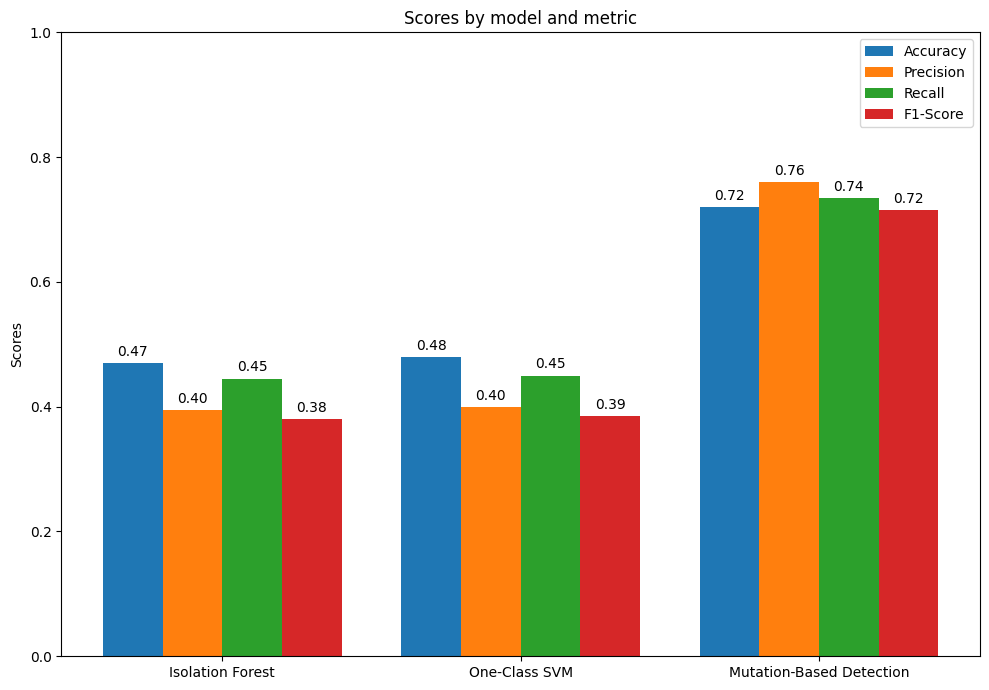

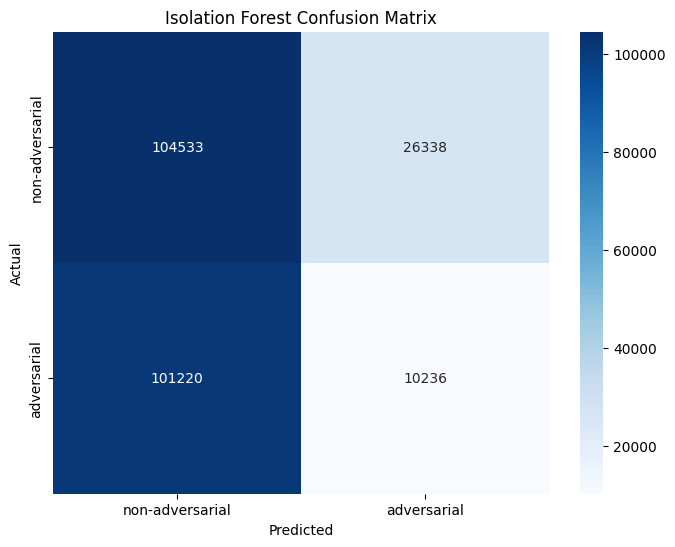

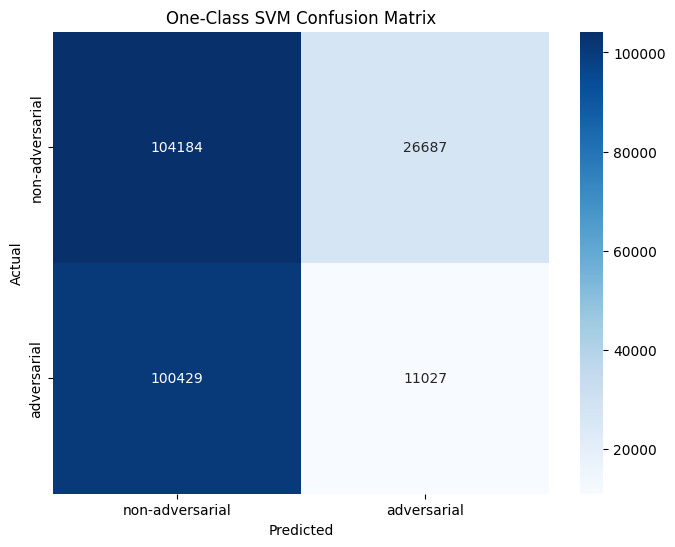

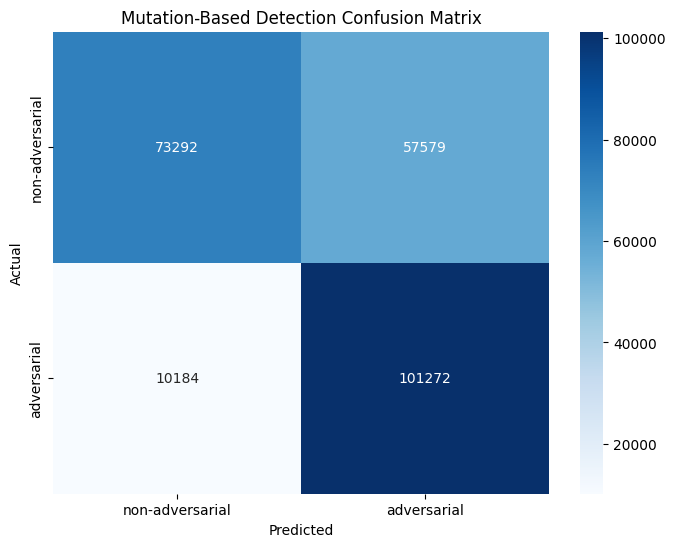

In [ ]:
# Displays Accuracy Metrics for Adversarial Defences

# Function to extract metrics from classification report
def extract_metrics(class_report):
    lines = class_report.strip().split('\n')
    metrics = {
        "accuracy": None,
        "precision": [],
        "recall": [],
        "f1-score": []
    }

    for line in lines:
        if 'accuracy' in line:
            metrics["accuracy"] = float(line.split()[-2])
        elif re.match(r'\s*\d+', line):
            parts = line.split()
            metrics["precision"].append(float(parts[1]))
            metrics["recall"].append(float(parts[2]))
            metrics["f1-score"].append(float(parts[3]))

    for key in ["precision", "recall", "f1-score"]:
        if len(metrics[key]) > 0:
            metrics[key] = sum(metrics[key]) / len(metrics[key])
        else:
            metrics[key] = 0.0

    return metrics

# Load the classification reports
with open('isolation_forest_classification_report.txt', 'r') as f:
    class_report_if = f.read()

with open('one_class_svm_classification_report.txt', 'r') as f:
    class_report_svm = f.read()

with open('mutation_based_classification_report.txt', 'r') as f:
    class_report_mb = f.read()

# Extract metrics from the reports
metrics_if = extract_metrics(class_report_if)
metrics_svm = extract_metrics(class_report_svm)
metrics_mb = extract_metrics(class_report_mb)

models = ['Isolation Forest', 'One-Class SVM', 'Mutation-Based Detection']
accuracy = [metrics_if['accuracy'], metrics_svm['accuracy'], metrics_mb['accuracy']]
precision = [metrics_if['precision'], metrics_svm['precision'], metrics_mb['precision']]
recall = [metrics_if['recall'], metrics_svm['recall'], metrics_mb['recall']]
f1_score = [metrics_if['f1-score'], metrics_svm['f1-score'], metrics_mb['f1-score']]

# Plot accuracy, precision, recall, and f1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-adversarial', 'adversarial'], yticklabels=['non-adversarial', 'adversarial'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def load_confusion_matrix(file_path):
    with open(file_path, 'r') as f:
        data = f.read().strip()
        data = re.sub(r'[\[\]]', '', data)
        data = np.array([int(num) for num in data.split()]).reshape(2, 2)
    return data

conf_matrix_if = load_confusion_matrix('isolation_forest_confusion_matrix.txt')
conf_matrix_svm = load_confusion_matrix('one_class_svm_confusion_matrix.txt')
conf_matrix_mb = load_confusion_matrix('mutation_based_confusion_matrix.txt')

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_if, 'Isolation Forest Confusion Matrix')
plot_confusion_matrix(conf_matrix_svm, 'One-Class SVM Confusion Matrix')
plot_confusion_matrix(conf_matrix_mb, 'Mutation-Based Detection Confusion Matrix')


In [ ]:
model_cicds.save('adversarial_training.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
